In [1]:
import subprocess
import tqdm
from pathlib import Path
import torch
import torch.nn as nn
import os
import numpy as np
from omegaconf import OmegaConf

import hydra
from hydra import compose, initialize
from hydra.core.hydra_config import HydraConfig

import sys
sys.path.append('../')
from src.utils.protein import from_pdb_file, to_pdb
from src.models.TorsionalDiffusion import TDiffusionModule
from src.datamodules.components.helper import *
from src.models.components import get_atom14_coords
from src.utils.protein_analysis import ProteinAnalysis

from pyrosetta import init, pose_from_pdb, get_fa_scorefxn, Pose, standard_packer_task
import pickle
import glob

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [2]:
initialize(version_base="1.3", config_path="../configs")
# initialize(config_path="configs")
cfg = compose(config_name="eval_diffusion.yaml", return_hydra_config=True)
HydraConfig().cfg = cfg
OmegaConf.resolve(cfg)

In [3]:
molprobity_clash_loc = '/home/zhangjk/MolProbity/build/bin/molprobity.clashscore'
tmp_dir = '/home/zhangjk/test/PackPPI/temp3'
pdb_files = glob.glob('/home/zhangjk/test/PackPPI/data/casp14_set/*.pdb')
output_pkl = '/home/zhangjk/test/PackPPI/decoys_clash_reu.pkl'
output_pdf = '/home/zhangjk/test/PackPPI/Figure3A2.pdf'
device = 'cuda:2' #"cpu"

protein_analysis = ProteinAnalysis(molprobity_clash_loc, tmp_dir)

In [4]:
model = TDiffusionModule.load_from_checkpoint(
    # allow one to evaluate with an older model using custom hyperparameters
    checkpoint_path=cfg.ckpt_path,
    map_location=device,
    strict=False,
    encoder_cfg=hydra.utils.instantiate(cfg.model.encoder_cfg),
    model_cfg=hydra.utils.instantiate(cfg.model.model_cfg),
    sample_cfg=hydra.utils.instantiate(cfg.model.sample_cfg)
)

model = model.to(device)
model.eval()


TDiffusionModule(
  (encoder): ProteinEncoder(
    (timestep_emb_func): SinusoidalEmbedding()
    (node_embedding): Linear(in_features=51, out_features=128, bias=True)
    (norm_nodes): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (edge_embedding): Linear(in_features=468, out_features=128, bias=True)
    (norm_edges): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (embeddings): PositionalEncodings()
  )
  (mpnn): MpnnNet(
    (mpnn_layers): ModuleList(
      (0-2): 3 x InvariantPointMessagePassing(
        (points_fn_node): Linear(in_features=128, out_features=24, bias=True)
        (points_fn_edge): Linear(in_features=128, out_features=24, bias=True)
        (node_message_fn): MLP(
          (W_in): Linear(in_features=456, out_features=128, bias=True)
          (W_inter): ModuleList(
            (0): Linear(in_features=128, out_features=128, bias=True)
          )
          (W_out): Linear(in_features=128, out_features=128, bias=True)
        )
        (edge_me

In [5]:
def preprocess_data(data):
    # Clean the data by removing empty lists
    cleaned_data = {k: v for k, v in data.items() if v}

    # Convert the data to Tensor
    keys = sorted(cleaned_data.keys())
    values = [cleaned_data[key] for key in keys]
    tensor = torch.tensor(values, dtype=torch.float)

    # Calculate mean and standard deviation, ignoring NaN values
    mean_tensor = torch.nanmean(tensor, dim=1, keepdim=True)
    std_tensor = torch.sqrt(torch.nanmean((tensor - mean_tensor) ** 2, dim=1, keepdim=True))

    # Z-score normalization
    normalized_tensor = (tensor - mean_tensor) / std_tensor

    # Fill NaN values with column means
    nan_mask = torch.isnan(normalized_tensor)
    normalized_tensor[nan_mask] = torch.nanmean(normalized_tensor)

    # Calculate mean and 25-75% confidence intervals of the normalized data
    mean_values = torch.nanmean(normalized_tensor, dim=0)
    q25_values = torch.quantile(normalized_tensor, 0.25, dim=0)
    q75_values = torch.quantile(normalized_tensor, 0.75, dim=0)
    
    return mean_values, q25_values, q75_values

def smooth_data(data, window_length=5, polyorder=2):
    # Apply Savitzky-Golay filter for smoothing
    return savgol_filter(data, window_length, polyorder)

def analyze_proteins(pdb_files, output_pkl, model, device):
    init('-mute all '
         '-ex1 -ex2 -ex3 -ex4 '
         '-ignore_unrecognized_res '
         '-ignore_zero_occupancy false '
         '-load_PDB_components false ' 
         '-relax:default_repeats 2 '
         '-no_fconfig ')
    
    scorefxn = get_fa_scorefxn()
    data = {}

    for i in tqdm.trange(len(pdb_files)):
        in_pdb = pdb_files[i]

        protein = vars(from_pdb_file(Path(in_pdb), mse_to_met=True))
        batch = protein_analysis.get_prot(in_pdb)
        batch = batch.to(device)

        clash_iter = []
        reu_iter = []

        try:
            SC_D_sample, SC_D_resample_list, _  = model.sampling(batch, use_proximal=True, return_list=True)
        except RuntimeError as e:
            torch.cuda.empty_cache()
            continue
            
        for num in range(len(SC_D_resample_list)):
            predict_xyz = get_atom14_coords(batch.X, batch.residue_type, batch.BB_D, SC_D_resample_list[num])
            protein['atom_positions'] = predict_xyz.cpu().squeeze().numpy()
            temp_protein = to_pdb(protein)
             
            with open(protein_analysis.tmp_pdb, 'w') as temp_file:
                temp_file.writelines(temp_protein)

            try:
                pose = pose_from_pdb(protein_analysis.tmp_pdb)
                score = scorefxn(pose)
                clash = protein_analysis.get_clashscore(protein_analysis.tmp_pdb)
            except RuntimeError as e:
                break

            reu_iter.append(score)
            clash_iter.append(clash)
        
        data[f'sample_{i}_clash'] = clash_iter
        data[f'sample_{i}_reu'] = reu_iter

        if i == 0:
            print(data)

    with open(output_pkl, 'wb') as f:
        pickle.dump(data, f)

def process_and_plot(data, output_pdf):
    # Process the data
    mean_values_clash, q25_clash, q75_clash = preprocess_data({k: v for k, v in data.items() if 'clash' in k})
    mean_values_reu, q25_reu, q75_reu = preprocess_data({k: v for k, v in data.items() if 'reu' in k})

    # Smooth the data
    mean_values_clash_smooth = smooth_data(mean_values_clash.numpy(), window_length=7, polyorder=2)
    q25_clash_smooth = smooth_data(q25_clash.numpy(), window_length=7, polyorder=2)
    q75_clash_smooth = smooth_data(q75_clash.numpy(), window_length=7, polyorder=2)

    mean_values_reu_smooth = smooth_data(mean_values_reu.numpy(), window_length=7, polyorder=2)
    q25_reu_smooth = smooth_data(q25_reu.numpy(), window_length=7, polyorder=2)
    q75_reu_smooth = smooth_data(q75_reu.numpy(), window_length=7, polyorder=2)

    # Plot the normalized line charts with confidence intervals
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Plot the clash data
    color = 'tab:blue'
    ax1.set_xlabel('Sample Index')
    ax1.set_ylabel('Normalized Clash Energy', color=color)
    ax1.plot(mean_values_clash_smooth, label='Mean (Clash)', color=color)
    ax1.fill_between(range(len(mean_values_clash_smooth)), q25_clash_smooth, q75_clash_smooth, color=color, alpha=0.2, label='25-75% Quantile (Clash)')
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis and plot the reu data
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Normalized Reu Energy', color=color)
    ax2.plot(mean_values_reu_smooth, label='Mean (Reu)', color=color)
    ax2.fill_between(range(len(mean_values_reu_smooth)), q25_reu_smooth, q75_reu_smooth, color=color, alpha=0.2, label='25-75% Quantile (Reu)')
    ax2.tick_params(axis='y', labelcolor=color)

    # Add legend
    fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

    plt.title('Normalized Energy with Confidence Interval (Smoothed)')
    plt.savefig(output_pdf, format='pdf')
    plt.show()

In [6]:
analyze_proteins(pdb_files, output_pkl, model, device)

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python39.ubuntu 2024.19+release.a34b73c40fe9c61558d566d6a63f803cfb15a4fc 2024-05-02T16:22:03] retrieved from: http://www.pyrosetta.org


  3%|█▉                                                               | 1/34 [02:17<1:15:39, 137.55s/it]

{'sample_0_clash': [15.37, 13.94, 13.66, 13.38, 15.08, 15.92, 13.09, 12.52, 12.24, 11.67, 11.67, 11.67, 11.38, 11.38, 11.1, 11.67, 11.38, 11.38, 12.79, 12.79, 13.08, 13.65, 13.65, 13.36, 13.65, 13.65, 13.36, 13.65, 13.65, 14.22, 14.22, 14.22, 13.93, 13.65, 13.65, 13.65, 13.65, 13.65, 13.65, 13.93, 13.65, 13.65, 13.36, 13.36, 13.36, 13.65, 13.36, 13.36, 13.65, 13.65], 'sample_0_reu': [1400.8108755569185, 1307.468888298674, 1217.6955799798186, 1131.726796632596, 1046.130318049002, 956.5932008105788, 868.9621279554992, 782.6323632318574, 703.6572741810887, 635.8133555445002, 575.9651504682496, 521.4017438410501, 469.27322525132354, 420.9181505235111, 379.03853562771735, 342.49769050667214, 310.1874664336196, 281.2159394539226, 255.71352616471364, 233.83613942635435, 214.19768232439526, 197.746428246609, 184.14686928001095, 172.56851841697636, 163.37950364442867, 155.89052581182608, 149.25159854115958, 143.5101196255003, 137.62269234407455, 131.9924430155241, 127.14803438060976, 122.086279

100%|████████████████████████████████████████████████████████████████| 34/34 [1:06:21<00:00, 117.11s/it]


In [8]:
with open(output_pkl, 'rb') as f:
    data = pickle.load(f)

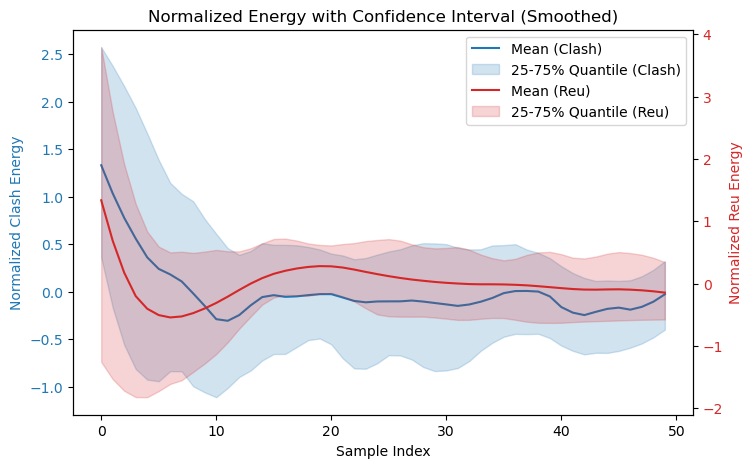

In [9]:
process_and_plot(data, output_pdf)